In [217]:
import pandas as pd
import numpy as np

In [218]:
import pandas as pd

# Load Excel file (adjust the path accordingly)
dataset = pd.read_excel("datasetclean.xlsx")

# Show first few rows



In [219]:
dataset.head()
#this is the processed dataset 


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [220]:
dataset.dtypes
#We can see that we have 4 columns that are non numeric.No worries , just use dummy variables
#in our regression model 

id                     int64
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

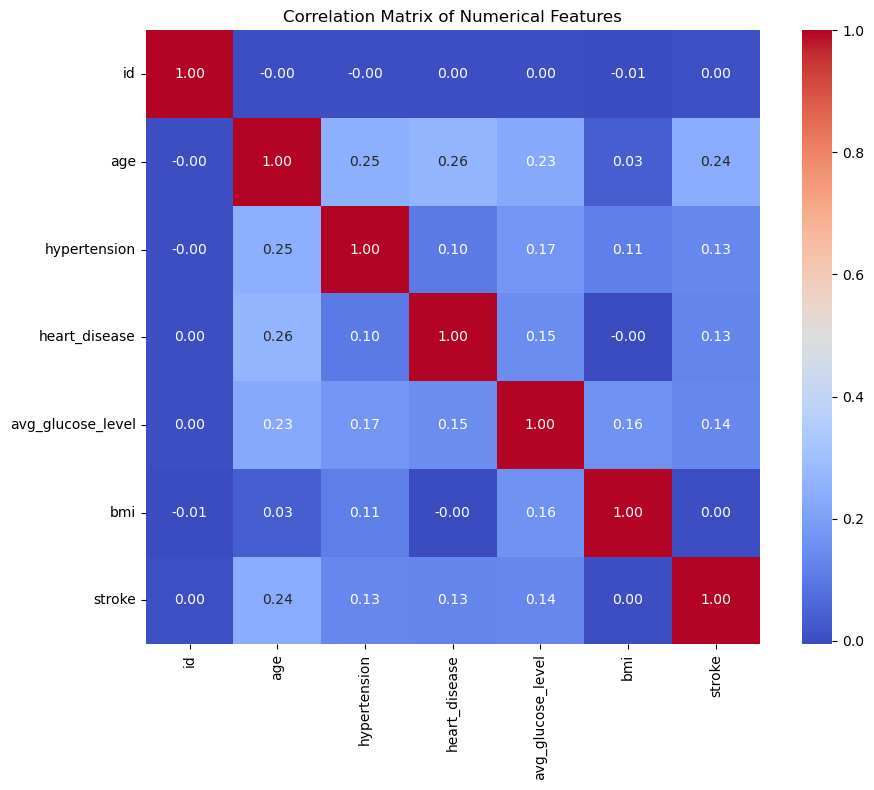

In [221]:
#in regerssion we dont want to include in the same model features highly corelated so lets check correlation 
#between our numerical features 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset


# Select only numerical columns
numerical_dataset = dataset.select_dtypes(include=["number"])

# Compute the correlation matrix
correlation_matrix = numerical_dataset.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


In [222]:
#We can see our nemerical features arent highly corelated so we can keep them all 

In [223]:
import pandas as pd
import scipy.stats as stats



# Define categorical and numerical features
categorical_features = dataset.select_dtypes(include=["object"]).columns.tolist()
numerical_features = dataset.select_dtypes(include=["number"]).columns.tolist()

# Perform ANOVA to see results 
anova_results = {}
for cat_feat in categorical_features:
    for num_feat in numerical_features:
        subset = dataset[[cat_feat, num_feat]].dropna()
        groups = [group[num_feat].values for name, group in subset.groupby(cat_feat)]
        if len(groups) > 1:
            f_stat, p_val = stats.f_oneway(*groups)
            anova_results[(cat_feat, num_feat)] = p_val

# Sort and show top 10
sorted_results = sorted(anova_results.items(), key=lambda x: x[1])
for (cat, num), pval in sorted_results[:10]:
    print(f"{cat} vs {num} --> p-value: {pval:.4e}")

ever_married vs age --> p-value: 1.5460e-201
work_type vs age --> p-value: 3.2302e-87
smoking_status vs age --> p-value: 1.9558e-28
ever_married vs bmi --> p-value: 1.6302e-12
ever_married vs avg_glucose_level --> p-value: 7.9135e-12
gender vs heart_disease --> p-value: 6.6768e-11
ever_married vs hypertension --> p-value: 1.1486e-09
smoking_status vs hypertension --> p-value: 2.4637e-08
work_type vs hypertension --> p-value: 1.5421e-07
gender vs avg_glucose_level --> p-value: 7.0813e-06


In [224]:
#There are significant differences in the numerical variable between the groups of the categorical variable.
#Due to the small p values , basically it means that we should keep them 
#

In [225]:
#lets get dummy variables 
# Convert categorical columns using one-hot encoding
dataset_encoded = pd.get_dummies(dataset, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'],    dtype=int,drop_first=True)


In [226]:
dataset_encoded.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67,0,1,228.69,36.6,1,1,1,0,1,0,1,1,0,0
1,31112,80,0,1,105.92,32.5,1,1,1,0,1,0,0,0,1,0
2,60182,49,0,0,171.23,34.4,1,0,1,0,1,0,1,0,0,1
3,1665,79,1,0,174.12,24.0,1,0,1,0,0,1,0,0,1,0
4,56669,81,0,0,186.21,29.0,1,1,1,0,1,0,1,1,0,0


In [227]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant




# Drop non-feature columns (like target and ID)
X = dataset_encoded.drop(columns=["stroke", "id"], errors='ignore')

# Add a constant (intercept) term for VIF calculation
X_const = add_constant(X)

# Create a DataFrame to store VIF values
vif_df = pd.DataFrame()
vif_df["Feature"] = X_const.columns

# Calculate VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Optional: drop the intercept row ('const'), we usually don't interpret its VIF
vif_df = vif_df[vif_df["Feature"] != "const"]

# Sort by highest VIF to make it easier to spot multicollinearity
vif_df = vif_df.sort_values(by="VIF", ascending=False)

# Show the top results
print(vif_df)


#Computes VIF to detect multicollinearity (i.e., when features are too similar).
#We can see we have low VIF values 


                           Feature       VIF
10         work_type_Self-employed  1.860529
9                work_type_Private  1.829165
13     smoking_status_never smoked  1.814293
12  smoking_status_formerly smoked  1.644000
1                              age  1.586589
14           smoking_status_smokes  1.567997
7                 ever_married_Yes  1.280209
4                avg_glucose_level  1.107831
3                    heart_disease  1.102757
2                     hypertension  1.102712
5                              bmi  1.051555
6                      gender_Male  1.022959
8           work_type_Never_worked  1.016583
11            Residence_type_Urban  1.003046


In [228]:
#Ready to build our  regression model but first we have to choose what type of regression 
#we can use linear or logistic regression , since our data is binary (stroke vs no stroke) lets proceed
#with loigstic regression

In [229]:
#lets first see the model if it is balanced or unbalanced 
dataset_encoded["stroke"].value_counts()


stroke
0    3863
1     208
Name: count, dtype: int64

In [230]:
#fuck, data is unbalanced lets undersample the stroke data since a regression 

In [231]:
#since we are building a regression model we are goind to use a rule of thump for 
#regression the "10 data points per feature" which are the datapoints per feature needed
#we have 208 rows and we need 208 / 15 ≈ 13.8 events per feature , sow we exceed the 10 
#events per feature , so just undersampling is enough and simple

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#lets first split majority/minority class 
df_majority = dataset_encoded[dataset_encoded["stroke"] == 0]
df_minority = dataset_encoded[dataset_encoded["stroke"] == 1]

# Randomly sample majority class to match minority count length as seen below 
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine undersampled majority with minority to build a df with same 1/0
df_balanced = pd.concat([df_majority_undersampled, df_minority], axis=0)

In [233]:
df_balanced["stroke"].value_counts()
#it worked ,perfect 

stroke
0    208
1    208
Name: count, dtype: int64

In [234]:
#lets proceed with regression 

Cross-Validation Accuracy Scores: [0.73809524 0.68674699 0.72289157 0.79518072 0.72289157]
Mean CV Accuracy: 0.7331612162937465
Confusion Matrix
[[30 12]
 [15 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        42
           1       0.69      0.64      0.67        42

    accuracy                           0.68        84
   macro avg       0.68      0.68      0.68        84
weighted avg       0.68      0.68      0.68        84


Feature Importance (Top Features):
                           Feature  Coefficient
0                              age     1.412469
3                avg_glucose_level     0.491319
1                     hypertension     0.465739
10            Residence_type_Urban     0.244491
8                work_type_Private     0.175624
13           smoking_status_smokes     0.130650
11  smoking_status_formerly smoked     0.125575
6                 ever_married_Yes     0.107567
4                 

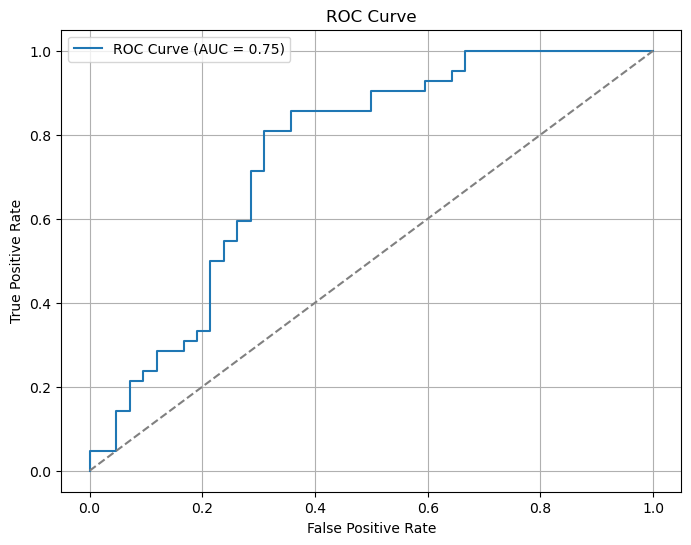

(None,)

In [280]:
#seperate labeled column vs variables (target(y) from variables(x) for regression)
X = df_balanced.drop(columns=["stroke", "id"], errors='ignore')
y = df_balanced["stroke"]

# scale features since some features are big numbers some small 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#rain/test split data 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2,stratify=y , random_state=42
)

# train logistic regression
model = LogisticRegression()
#we have already transform the data on scaling no need to fit_transform just fit 
model.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score
# perform cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# prredict and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

# feature importance (logistic regression coefficients to see how important each feature is)
import numpy as np
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(model.coef_[0])
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Top Features):")
print(feature_importance)

# have a look at roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show() , 


In [236]:
#please just note that married is correlated with the results (wonder why??) 
#dont forget though married people tend to be older as well 

In [237]:
#### model sucks , horrible results , model is trash , lets do something else instead
#of undersampling lets add at our regression training (class_weight='balanced') to
#train the undersampled class more , it will probably wont work but for the "timi ton oplon" lets 
#give it a shot 

🔍 Confusion Matrix:
[[555 218]
 [ 10  32]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       773
           1       0.13      0.76      0.22        42

    accuracy                           0.72       815
   macro avg       0.56      0.74      0.52       815
weighted avg       0.94      0.72      0.80       815



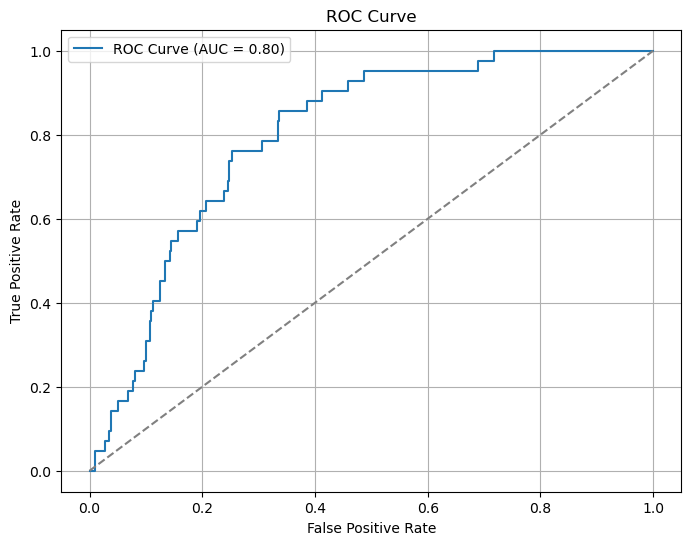

In [238]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


df = dataset_encoded 

#Split features (X) and target (y)
X = df.drop(columns=["stroke", "id"], errors='ignore')
y = df["stroke"]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (keep original imbalance, but stratify now )
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# train Logistic Regression with `class_weight='balanced'`
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve

# print Confusion Matrix & Classification Report
print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [239]:
#even worse results , utterly trash as expected 

In [240]:
#lets try SMOTE AS WELL
#SMOTE generates synthetic results for the minority class which is stroke 


Cross-Validation Accuracy Scores: [0.75097025 0.76375405 0.74757282 0.74563107 0.78705502]
Mean CV Accuracy: 0.7589966381558841

Confusion Matrix
[[549 224]
 [154 619]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       773
           1       0.73      0.80      0.77       773

    accuracy                           0.76      1546
   macro avg       0.76      0.76      0.75      1546
weighted avg       0.76      0.76      0.75      1546


Feature Importance (Top Features):
                           Feature  Coefficient
0                              age     1.576078
13           smoking_status_smokes     0.312416
3                avg_glucose_level     0.210896
8                work_type_Private     0.194662
1                     hypertension     0.188582
11  smoking_status_formerly smoked     0.175773
12     smoking_status_never smoked     0.140562
6                 ever_married_Yes     0.111137
9          wo

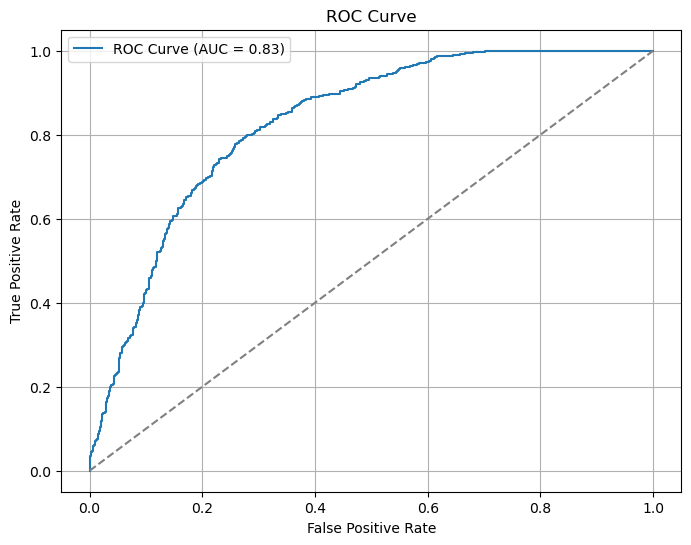

In [241]:
#### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Prepare features and target
X = dataset_encoded.drop(columns=["stroke", "id"], errors='ignore')
y = dataset_encoded["stroke"]

#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train/test split on the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2,stratify=y_resampled, random_state=42
)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Cross-validation on resampled dataset
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Predictions and evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(model.coef_[0])
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Top Features):")
print(feature_importance)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [242]:
#OOOOOOUUUUUUUIIIIII SMOTE gave better results , good job 

In [243]:
#Lets try something else as well , lets try to build a regression model by keeping only the numerical data 
#we have seen by doing some math about regresion like ANOVA etc.. that keeping categorical features
#should help , lets put this to the test by performing SMOTE as well to fix imbalance dataset

Cross-Validation Accuracy Scores: [0.75226391 0.75404531 0.74045307 0.74239482 0.77605178]
Mean CV Accuracy: 0.7530417781350348

Confusion Matrix
[[560 213]
 [164 609]]

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       773
           1       0.74      0.79      0.76       773

    accuracy                           0.76      1546
   macro avg       0.76      0.76      0.76      1546
weighted avg       0.76      0.76      0.76      1546


Feature Importance (Top Features):
             Feature  Coefficient
0                age     1.348651
3  avg_glucose_level     0.225452
1       hypertension     0.205776
2      heart_disease     0.090228
4                bmi     0.056950


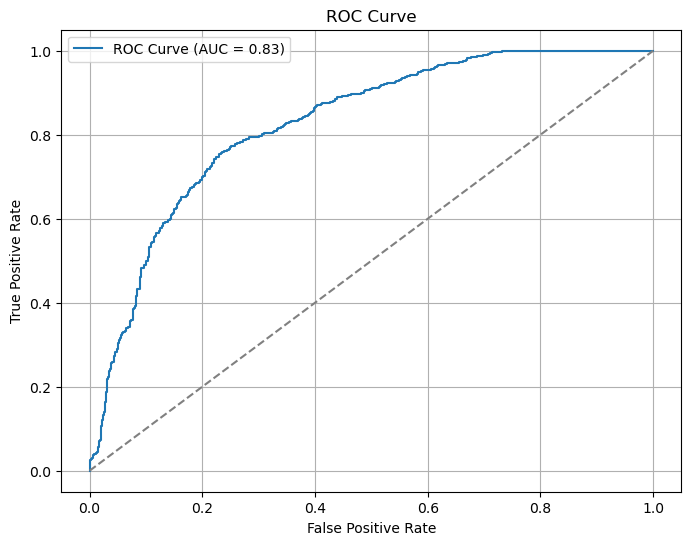

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load dataset
dataset = pd.read_excel("datasetclean.xlsx")

# Select only numerical features
numerical_features = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"]
X = dataset[numerical_features]
y = dataset["stroke"]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Train logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Predictions & Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': numerical_features,
    'Coefficient': np.abs(model.coef_[0])
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Top Features):")
print(feature_importance)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [245]:
#Accuracy is the same (0.76)
#Recall for stroke (1) is slightly better with categorical features (0.80 vs. 0.79)
#Precision is slightly better for numerical only (0.74 vs. 0.73)
#Categorical features add a tiny improvement to recall but not much to precision

#So results are categorical features add a tiny improvement, but numerical-only is simpler and just as effective.

In [246]:
#AND THE WINNER IS :Keeping categorical , using SMOTE for creating synthetic data for the undersampling class
#and accepting that you will not have 100% accuracy in health idnustry  so some people will die 